# Recurrent Neural Networks (RNN)

Training RNN Model...
Epoch 0/100, Loss: 1.1023
Epoch 10/100, Loss: 0.9719
Epoch 20/100, Loss: 0.9402
Epoch 30/100, Loss: 0.9348
Epoch 40/100, Loss: 0.9260
Epoch 50/100, Loss: 0.9190
Epoch 60/100, Loss: 0.9119
Epoch 70/100, Loss: 0.9034
Epoch 80/100, Loss: 0.8906
Epoch 90/100, Loss: 0.8732
Plotting decision boundary for RNN...


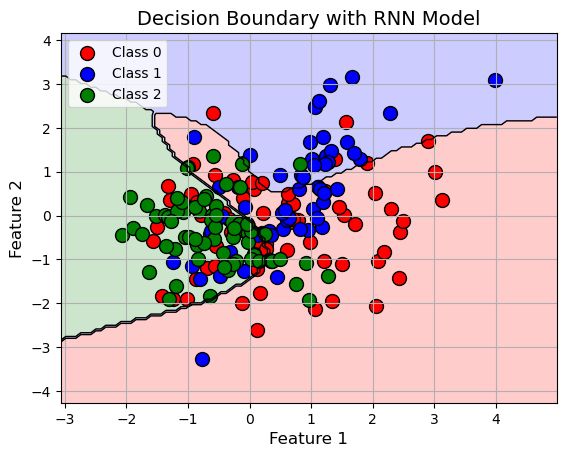

In [2]:
# Import necessary libraries
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate a more complex dataset with 3 classes
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_classes=3,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=0.5,
    flip_y=0.1,
    random_state=42
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define the RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Use the last output for classification
        x = self.fc(x)
        return x

# Initialize the model
input_size = 2
hidden_size = 16
output_size = 3  # 3 classes

rnn_model = RNN(input_size, hidden_size, output_size)

# Choose optimizer and loss function
criterion = nn.CrossEntropyLoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.01)

# Train the RNN Model
def train_rnn_model(model, optimizer, X_train_tensor, y_train_tensor, epochs=100):
    # Reshape for RNN: (batch_size, sequence_length, input_size)
    X_train_tensor_rnn = X_train_tensor.unsqueeze(1)  # Add sequence length dimension
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor_rnn)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

# Train RNN model
print("Training RNN Model...")
train_rnn_model(rnn_model, rnn_optimizer, X_train_tensor, y_train_tensor)

# Visualizing the decision boundary
def plot_decision_boundary(X, y, model, num_classes, rnn=False):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    
    if rnn:
        grid = grid.unsqueeze(1)  # Reshape for RNN: (batch_size, sequence_length, input_size)

    model.eval()
    with torch.no_grad():
        Z = model(grid)
        Z = torch.argmax(Z, axis=1).numpy()
    
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.2, colors=['red', 'blue', 'green'], levels=np.arange(-0.5, 3, 1))
    plt.contour(xx, yy, Z, levels=np.arange(-0.5, 3, 1), colors='black', linewidths=1)

    colors = ['red', 'blue', 'green']
    for i in range(num_classes):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=colors[i], label=f"Class {i}", edgecolor='k', s=100)
    
    plt.title("Decision Boundary with RNN Model", fontsize=14)
    plt.xlabel("Feature 1", fontsize=12)
    plt.ylabel("Feature 2", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot decision boundaries for RNN model
print("Plotting decision boundary for RNN...")
plot_decision_boundary(X, y, rnn_model, num_classes=3, rnn=True)
